In [ ]:
#!pip install -U jupyter
#!pip install torch
#!pip install torchsummary
#!pip install torchvision
#!pip install tensorflow-gpu
#!pip install pycocotools
#!conda remove tensorflow-gpu
!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.5/index.html
!pip install opencv-python 

In [ ]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())
device = torch.device("cuda") 

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import random
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import deepdish as dd
import pycocotools as pycoco
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'detectron2'

#### Some detectron2 utilities

In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from skimage import measure

In [5]:
datacsv = pd.read_csv('../data/processed/for_keras_generator.csv')

def get_local_image(number):
    im = Image.open(datacsv["filepath"][number])
    return im

### Now create a detectron config and defaultPredictor to run inference

In [6]:
cfg =get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #model threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

### load image ges and build dataset with only 1 fish ditected.

In [ ]:
annotations = {'image':[],
             'outputs':[]
             }
size = 0
for k in tqdm(range(2000)):
    outputs = predictor(np.array(get_local_image(k)))
    
    labels = outputs["instances"].pred_classes.cpu().numpy()
    #get only single fish predictions
    if len(labels) ==1 and all(labels==14):
        size+=1
        annotations['image'].append('%s'%k)
        annotations['outputs'].append(outputs)
        #print(k, ":%s "%labels)
        
    del outputs,labels
print("total: %s images of fish"%size)    
#dd.io.save('single_fish_with_annotations_%s.h5'%size, annotations)

In [17]:
import pickle
with open('single_fish_with_annotations_%s.plk'%size, 'wb') as f:
    pickle.dump(annotations, f, pickle.HIGHEST_PROTOCOL)
print(size)

429


### Visualize base model inference

<Figure size 432x288 with 0 Axes>

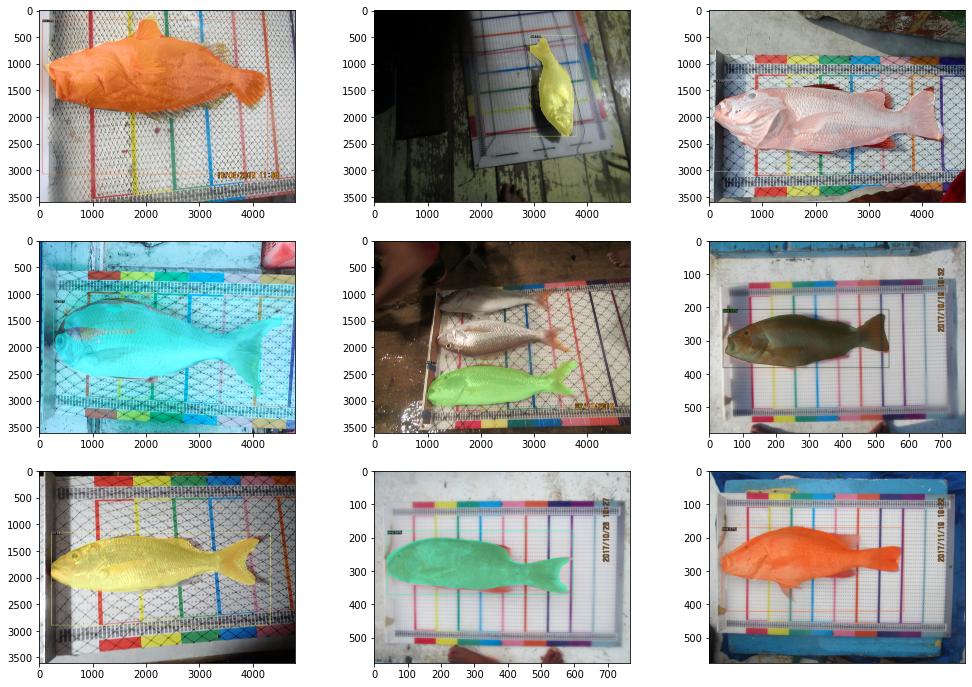

In [9]:
plt.figure()

r = c = 3
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])

for i in range(r):
    for j in range(c):
        p=np.random.randint(size)
        k = int(annotations['image'][p])
        #print('fish number: %s'%k)
        im_array = np.array(get_local_image(k))
        v = Visualizer(im_array[:,:,::-1],MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),scale=1.2)
        v = v.draw_instance_predictions(annotations['outputs'][p]['instances'].to("cpu"))
        axarr[i][j].imshow(Image.fromarray(v.get_image()[:,:,::-1]))
plt.show(block=True)

In [10]:
annotations["outputs"][0]

{'instances': Instances(num_instances=1, image_height=3000, image_width=4000, fields=[pred_boxes: Boxes(tensor([[ 814.9131, 1878.9651, 3295.1951, 2608.1890]], device='cuda:0')), scores: tensor([0.6666], device='cuda:0'), pred_classes: tensor([14], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]], device='cuda:0')])}

-----

boundaries = [
([17, 15, 100], [50, 56, 200]),
([4, 200, 4], [220, 250, 220]),
([25, 146, 190], [62, 174, 250]),
([103, 86, 65], [145, 133, 128])
]

lower, upper = boundaries[1]
lower = np.array(lower, dtype = "uint8")
upper = np.array(upper, dtype = "uint8")
#find the colors within the specified boundaries and apply
#the mask
mask = cv2.inRange(image, lower, upper)
output = cv2.bitwise_and(image, image, mask = mask)
#show the images

-----

## load annotations

In [16]:
#size = 713
if size is None:
    size = 713
annotations = dd.io.load("single_fish_with_annotations_%s.h5"%size)

In [11]:
### Train test annotation split 
from sklearn.model_selection import train_test_split as tts
annoDf = pd.DataFrame(annotations)
train_annotations,test_annotations = tts(annoDf,test_size = 0.25, random_state = 42)
train_annotations = train_annotations.reset_index()
test_annotations = test_annotations.reset_index()

data = {'train':train_annotations,'val':test_annotations}
del annoDf,train_annotations, test_annotations

## Train on  a custom dataset (fine tuning)

first need to register a dataset in the coco formart  to work with predefined data loaders


In [12]:
def create_dataset(annotation):
    dataset_dicts = []
    for im in range(len(annotation['image'])):
        act_img_num = int(annotation['image'][im])
        dict1 = {}
        dict1["file_name"] = datacsv["filepath"][act_img_num]
        
        #height, width = cv2.imread(dict1["file_name"]).shape[:2]
        
        #dict1["height"] = height
        #dict1["width"] = width
        dict1["image_id"] = act_img_num
        
        bbox = list(k for k in annotation["outputs"][im]["instances"].pred_boxes.tensor.cpu().numpy()[0])
        
        #RLE
        mask = list(annotation["outputs"][im]["instances"].pred_masks.cpu().numpy())[0]
        RLE_mask  = pycoco.mask.encode(np.asarray(mask, order = "F"))
        
        #poly mask
        
        
        area = pycoco.mask.area(RLE_mask)
        contours = measure.find_contours(np.asarray(mask, order = "F"),0.5)
        poly_mask = []
        
        for cont in contours:
            cont = np.flip(cont,axis=1)
            segmentation = cont.ravel().tolist()
            poly_mask.append(segmentation)
        
        
        dict1["annotations"] = []
        
        obj = {"bbox":bbox,
               "bbox_mode":BoxMode.XYXY_ABS,
                "category_id":0,
                "iscrowd":0,
                "segmentation": poly_mask}
        
        dict1["annotations"].append(obj)
            
        dataset_dicts.append(dict1)
    return dataset_dicts

### Register dataset

In [13]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()
for d_set in data:
    DatasetCatalog.register("fishNet_%s"%d_set, lambda d_set=d_set: create_dataset(data[d_set]))
    MetadataCatalog.get("fishNet_%s"%d_set).set(thing_classes = ["fish"])

### check dataset registration success, load visualize annotations ontop of image

<Figure size 432x288 with 0 Axes>

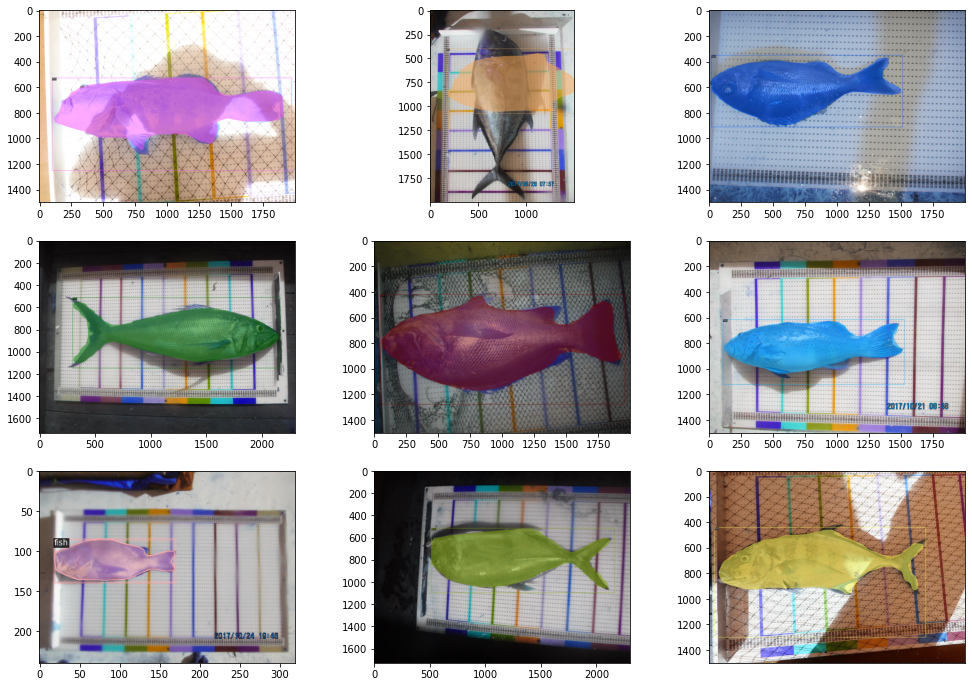

In [14]:
fish_metadata = MetadataCatalog.get("fishNet_train")
dataset_dicts = create_dataset(data["train"])

plt.figure()

r = c = 3
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])
i=0
j=0
for d in random.sample(dataset_dicts,r*c):
    if i == r:
        i = 0
        j+=1
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata = fish_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    axarr[i][j].imshow(Image.fromarray(vis.get_image()[:,:,::-1]))
    i+=1
    
plt.show()

-----

## Train

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fishNet_train",)
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0002
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

### Tensorboard

In [ ]:
%matplotlib inline 
%reload_ext tensorboard
%tensorboard --logdir output

## Inference 

In [ ]:
from detectron2.utils.visualizer import ColorMode

# load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
# Set training data-set path
cfg.DATASETS.TEST = ("fishNet_val", )
# Create predictor (model for inference)
predictor = DefaultPredictor(cfg)

plt.figure()

r = 2
c = 2
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])
i=0
j=0

dataset_dicts = create_dataset(data["val"])
for d in random.sample(dataset_dicts, r*c):
    if i == r:
        i = 0
        j+=1
        
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axarr[i][j].imshow(Image.fromarray(v.get_image()[:, :, ::-1]))
    i+=1
plt.show()

----

### random fish inference (could be more than one fish in image)

In [ ]:

annotations2 = {'image':[],
             'outputs':[]
             }
size = 0
for k in tqdm(range(500)):
    p = np.random.randint(10000)
    outputs = predictor(np.array(get_local_image(k)))

    labels = outputs["instances"].pred_classes.cpu().numpy()
    #get only single fish predictions
    if len(labels) > 3:
        size+=1
        annotations2['image'].append('%s'%p)
        annotations2['outputs'].append(outputs)
        #print(k, ":%s "%labels)
print("total: %s images of fish"%size)    
dd.io.save('any_fish_with_annotations_%s.h5'%size, annotations2)

annoDf = pd.DataFrame(annotations2)

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()
DatasetCatalog.register("fishNet_test", lambda d_set=d_set: create_dataset(annoDf))

In [ ]:
from detectron2.utils.visualizer import ColorMode

# load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
# Set training data-set path
cfg.DATASETS.TEST = ("fishNet_test", )
# Create predictor (model for inference)
predictor = DefaultPredictor(cfg)

plt.figure()

r = 1
c = 1
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])
i=0
j=0

dataset_dicts = create_dataset(annoDf)
for d in random.sample(dataset_dicts, r*c):
    if i == r:
        i = 0
        j+=1
        
    #im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axarr.imshow(Image.fromarray(v.get_image()[:, :, ::-1]))
    i+=1
plt.show()

### Evaluation on the validation set